In [1]:
from datetime import datetime

import incense
import matplotlib.pyplot as plt
import numpy as np
from incense import ExperimentLoader


In [2]:
loader = ExperimentLoader(db_name="sacred")


In [3]:
def parse_params(s: str) -> dict:
    """Parse a string of space-separated key=value pairs into a dictionary.

    Example:
        >>> parse_params("a=10 b=1e-4 c=bab | some comment # whatever else")
        {'a': 10, 'b': 0.0001, 'c': 'bab'}
    """
    result = {}
    pairs = s.strip().split()

    for pair in pairs:
        try:
            key, value = pair.split("=")
        except Exception:
            continue
        try:
            value = float(value)
            if value.is_integer():
                value = int(value)
        except ValueError:
            pass
        result[key] = value

    return result


print(parse_params("a=10 b=1e-4 c=bab | some comment # whatever else"))


{'a': 10, 'b': 0.0001, 'c': 'bab'}


In [4]:
from collections import defaultdict
from pprint import pprint

lists = defaultdict(list)

for exp in loader.find_all():
    notes = exp.meta["comment"]
    if "random-1" not in notes:
        continue
    print(notes)
    try:
        params = parse_params(notes)
        epochs = params["epochs"]
        lr = params["lr"]
        losses = exp.metrics["loss"][-3:]
        avg = sum(losses) / len(losses)
        lists[(epochs, lr)].append(avg)
    except Exception:
        continue


In [25]:
from collections import defaultdict
from pprint import pprint

lists = defaultdict(list)
names = ["slope"]  # , "fixed-steps"]

for exp in loader.find_all():
    notes = exp.meta["comment"]
    if not any(name in notes for name in names):
        continue

    try:
        params = parse_params(notes)
        step = params["step"]
        w = params.get("w", None)
        if params["k"] == "AR":
            w = 1
        elif params["k"] == "D":
            w = 40
        value = min(exp.metrics["q50"])
        lists[(step, w)].append(value)
    except Exception:
        continue


In [26]:
lists


defaultdict(list,
            {(2, 1): [0.13596975803375244,
              0.09630272537469864,
              0.11077255755662918],
             (2, 2): [0.07581205666065216,
              0.11007978022098541,
              0.12010888010263443],
             (2, 3): [0.10325109958648682,
              0.09566108137369156,
              0.078392893075943],
             (2, 4): [0.06763400882482529,
              0.06612727046012878,
              0.05056513100862503],
             (2, 5): [0.06490104645490646,
              0.08110973238945007,
              0.03569965809583664],
             (2, 6): [0.029445253312587738,
              0.07299302518367767,
              0.09399618208408356],
             (2, 8): [0.04325634613633156,
              0.0576593391597271,
              0.05186224728822708],
             (2, 10): [0.05442647635936737,
              0.043818190693855286,
              0.0633229911327362],
             (2, 12): [0.043346356600522995,
              0.0492718368

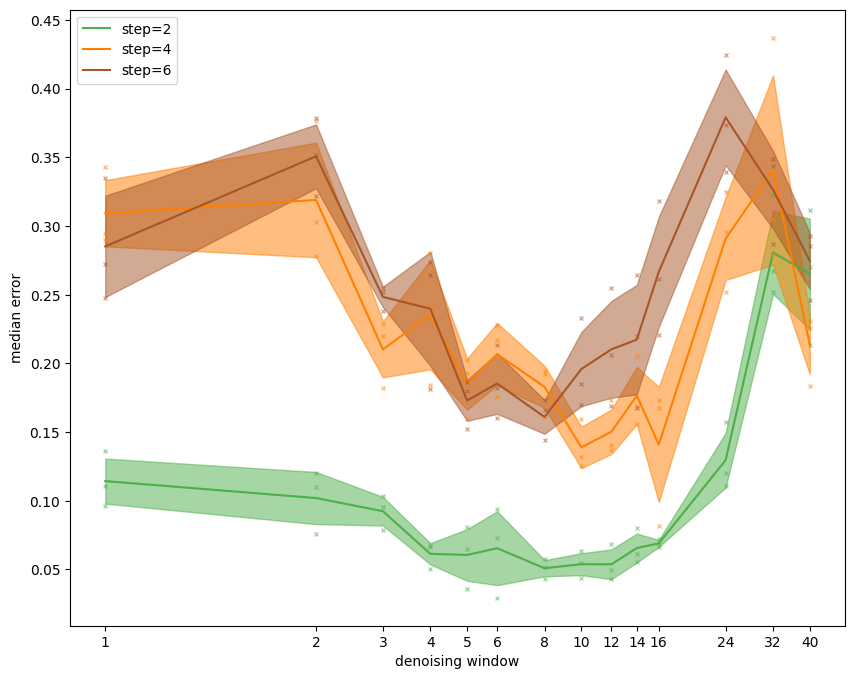

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in lists])))
steps = sorted(list(set([step for (step, w) in lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))

for step, color in zip(steps, colors):
    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = lists[(step, w)]
        cur = [x for x in cur if x < 2]
        if len(cur) > 0:
            means.append(np.mean(cur))
            stds.append(np.std(cur))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "x", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.5, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.legend()
plt.show()
